In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install keras-tuner --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00


In [3]:
import os
import cv2
import random
import numpy as np
import pandas as pd
from PIL import Image
from skimage import exposure
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import keras_tuner
from keras import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Activation,Dropout,BatchNormalization,InputLayer
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

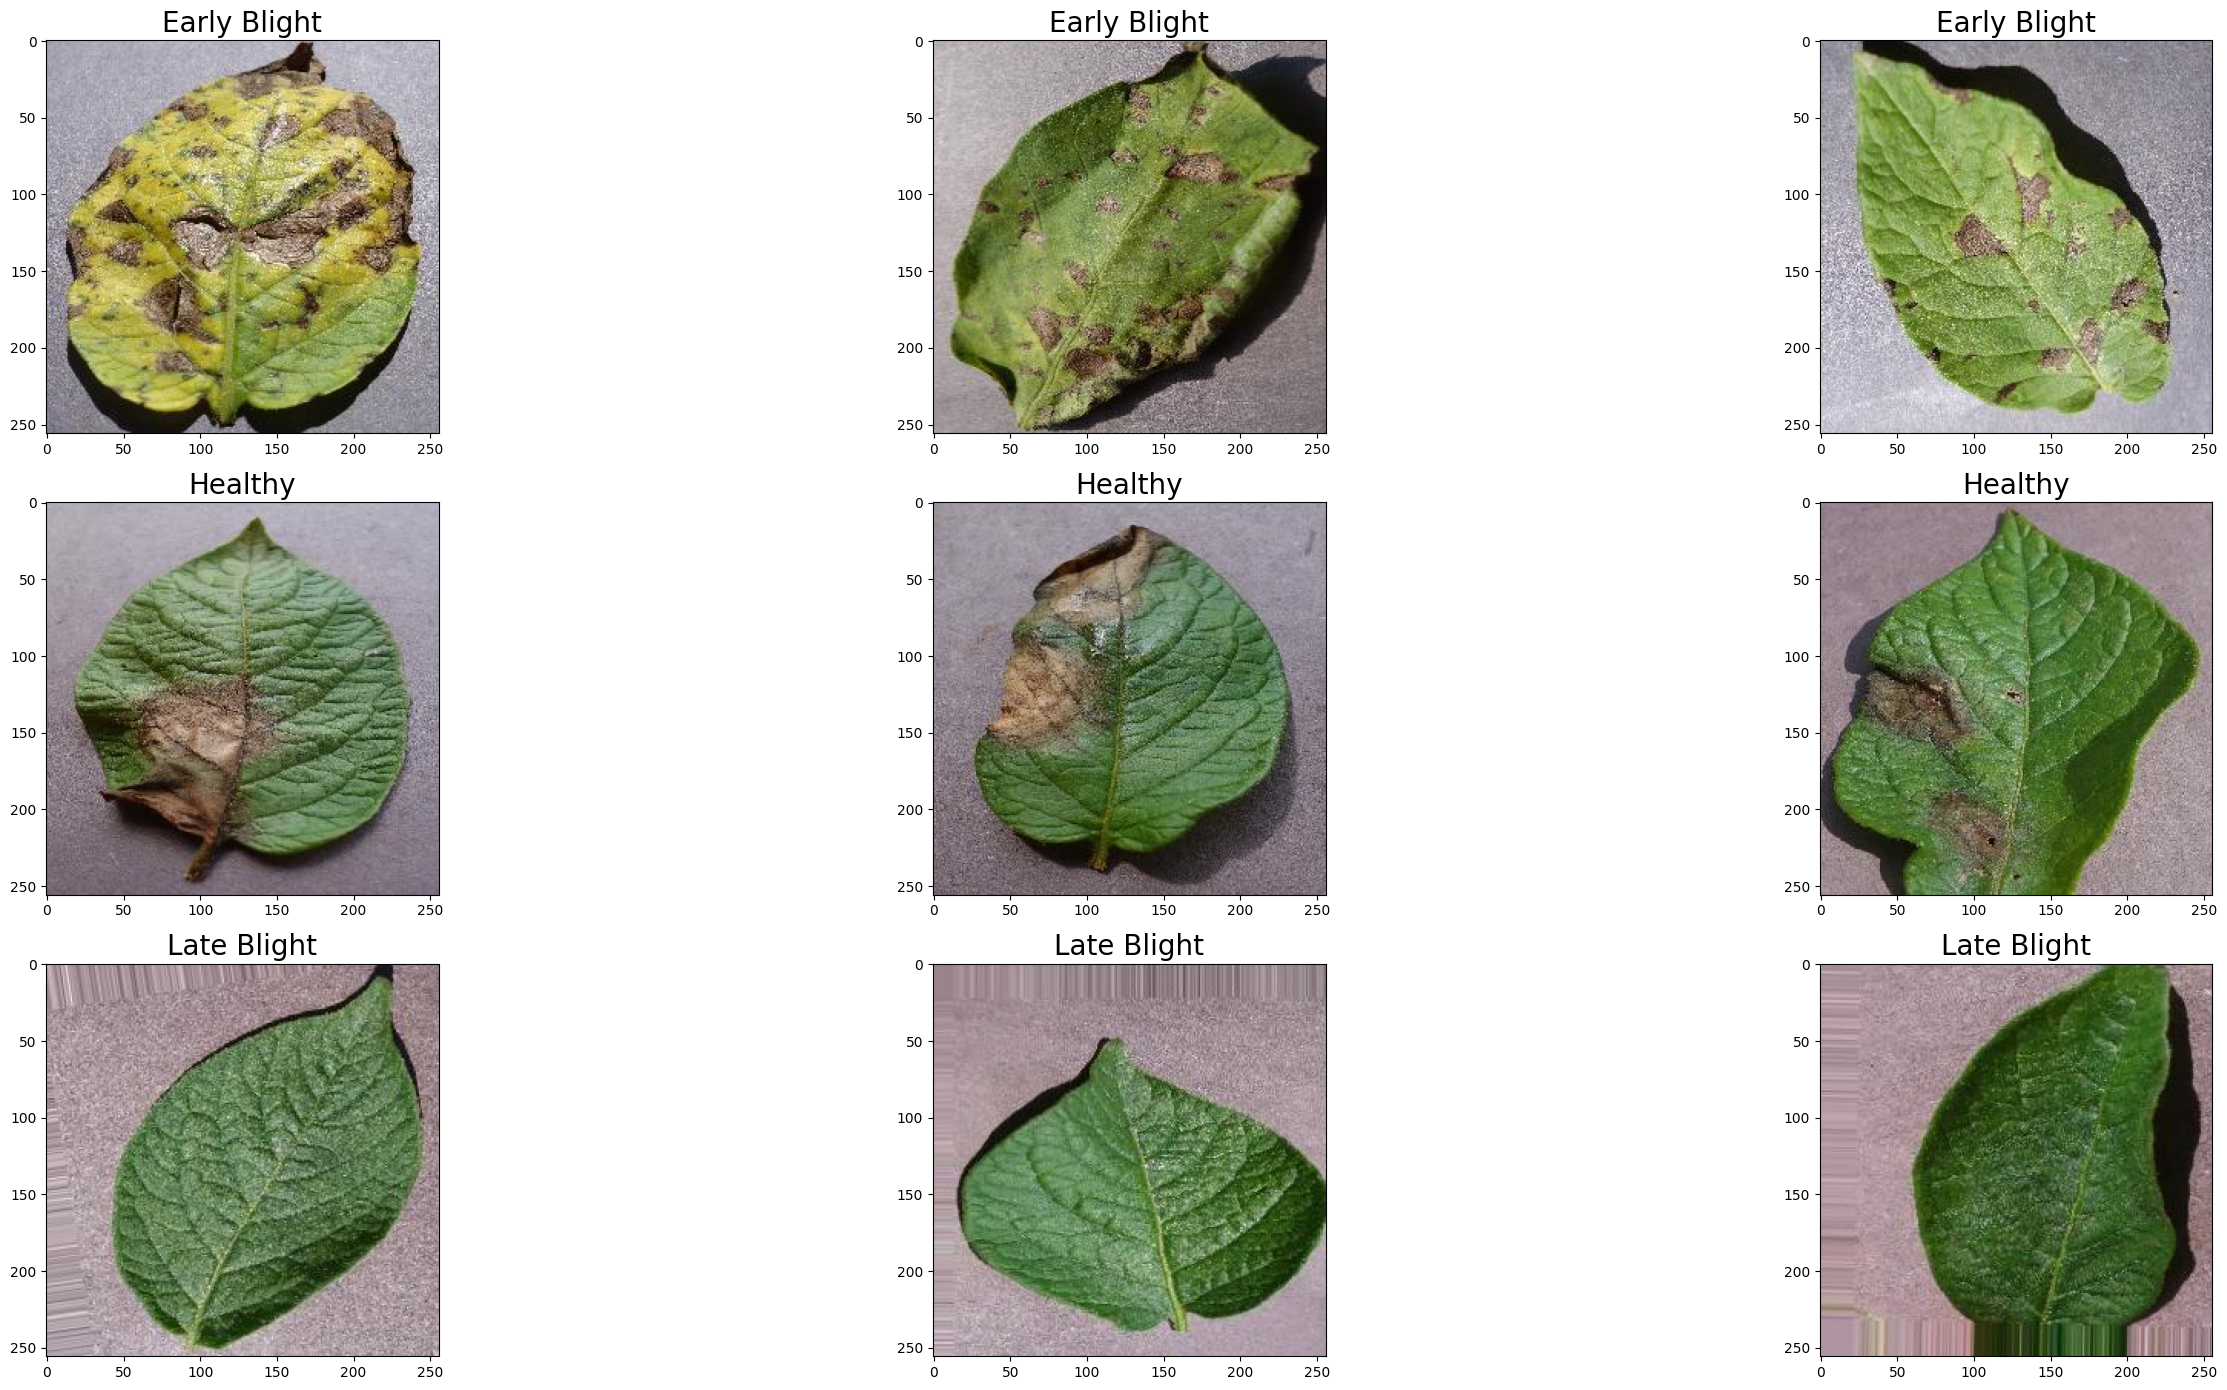

In [4]:
# Define the paths to your image directories
Early_Blight_path = '/content/drive/MyDrive/3.1/Ml/project/data/blight/Potato___Early_blight'
Healthy_path = '/content/drive/MyDrive/3.1/Ml/project/data/blight/Potato___Late_blight'
Late_Blight = '/content/drive/MyDrive/3.1/Ml/project/data/blight/Potato___healthy'


image_files = [os.path.join(Early_Blight_path, filename) for filename in os.listdir(Early_Blight_path)]
image_files2 = [os.path.join(Healthy_path, filename) for filename in os.listdir(Healthy_path)]
image_files3 = [os.path.join(Late_Blight, filename) for filename in os.listdir(Late_Blight)]

num_samples = 3

selected_images = random.sample(image_files, num_samples)
selected_images2 = random.sample(image_files2, num_samples)
selected_images3 = random.sample(image_files3, num_samples)

#create subplots for displaying images
fig, axes = plt.subplots(3, num_samples, figsize=(30,14))

# Display each selected image from the first directory
for i, image_path in enumerate(selected_images):
    ax = axes[0, i]
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title('Early Blight', fontsize=20)  # Increase font size for the title
    ax.axis('on')  # Show axis

# Display each selected image from the second directory
for i, image_path in enumerate(selected_images2):
    ax = axes[1, i]
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title('Healthy', fontsize=20)  # Increase font size for the title
    ax.axis('on')  # Show axis

# Display each selected image from the third directory
for i, image_path in enumerate(selected_images3):
    ax = axes[2, i]
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.set_title('Late Blight', fontsize=20)  # Increase font size for the title
    ax.axis('on')  # Show axis

# Show the images
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
target_size = (250, 250)

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Split 20% for validation
)

# Only rescaling for test data
test_datagen = ImageDataGenerator(rescale=1./255)

# Directory path where all your class folders are located
data_dir = '/content/drive/MyDrive/3.1/Ml/project/data/blight/'

# Flow from directory for training data with validation split
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    subset='training'  # Set as training data
)

# Flow from directory for validation data
validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',  # Use 'categorical' for multi-class classification
    subset='validation'  # Set as validation data
)

# Assuming a separate test folder if you have one
# Flow from directory for test data
test_generator = test_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical'
)


Found 240 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [7]:
model = Sequential()

model.add(Conv2D(256,kernel_size=(3,3),padding='same',activation='relu',input_shape=(250,250,3),kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))

model.add(Conv2D(164,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))

model.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))

model.add(Flatten())

model.add(Dense(128,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001),kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dense(3,activation='softmax'))

In [8]:
from tensorflow.keras.optimizers import Adadelta
optimizer = Adadelta(learning_rate=1.0, rho=0.95)


model.compile(optimizer = optimizer,loss = 'binary_crossentropy', metrics = ['accuracy'])

In [9]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

CALLBACKS = [early_stopping_cb]

In [10]:
history = model.fit(
    train_generator,
    callbacks=CALLBACKS,
    epochs=100,
    validation_data=validation_generator
)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 145s 8s/step - accuracy: 0.5705 - loss: 2.0554 - val_accuracy: 0.3333 - val_loss: 10.0603
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 615ms/step - accuracy: 0.9413 - loss: 1.7261 - val_accuracy: 0.3333 - val_loss: 7.1154
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 528ms/step - accuracy: 0.8687 - loss: 1.7385 - val_accuracy: 0.4500 - val_loss: 4.7538
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 495ms/step - accuracy: 0.8703 - loss: 1.6705 - val_accuracy: 0.5000 - val_loss: 3.0049
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 528ms/step - accuracy: 0.9182 - loss: 1.5955 - val_accuracy: 0.3333 - val_loss: 2.6319
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 499ms/step - accuracy: 0.9396 - loss: 1.5621 - val_accuracy: 0.7167 - val_loss: 1.8996
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 498ms/step - accuracy: 0.9311 - loss: 1.5232 - val_accuracy: 0.5667 - val_loss: 1.8758
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 711ms/step - accuracy: 0.9574 - loss: 1.4889 - val_accuracy: 0.4167 

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 250, 250, 256)       │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 250, 250, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 125, 125, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 164)       │         378,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 164)       │             656 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 63, 63, 164)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 63, 63, 64)          │          94,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 63, 63, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 65536)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       8,388,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,642,327 (101.63 MB)

 Trainable params: 8,880,303 (33.88 MB)

 Non-trainable params: 1,416 (5.53 KB)

 Optimizer params: 17,760,608 (67.75 MB)

In [12]:
Evaluation = model.evaluate(test_generator)

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 749ms/step - accuracy: 0.8401 - loss: 1.5459


In [13]:
Evaluation

[1.5604192018508911, 0.8333333134651184]

In [14]:
print("Accuracy of this model is :" ,Evaluation[1]*100,"%")

Accuracy of this model is : 83.33333134651184 %


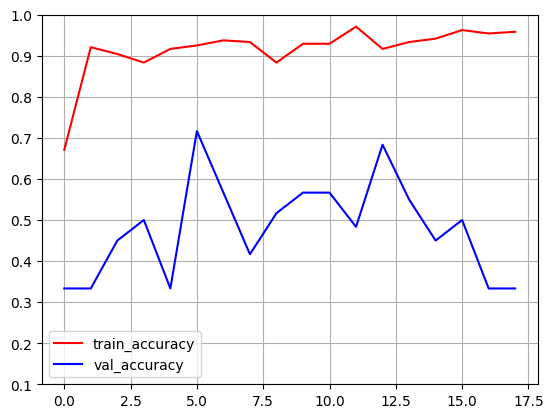

In [15]:
plt.plot(history.history['accuracy'], color='red', label='train_accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='val_accuracy')
plt.legend()
plt.grid()

# Set y-axis limits from 0.1 to 10
plt.ylim(0.1, 1.0)

plt.show()

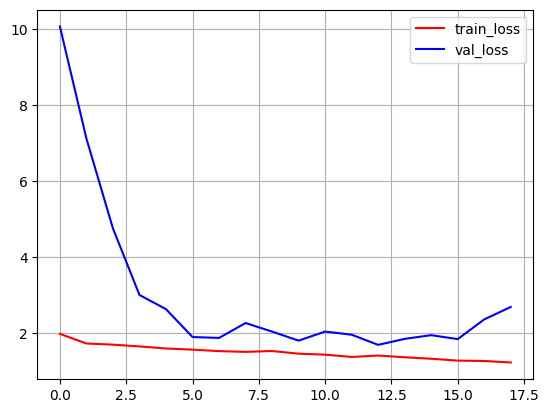

In [16]:
plt.plot(history.history['loss'], color = 'red', label = 'train_loss')
plt.plot(history.history['val_loss'], color = 'blue', label = 'val_loss')
plt.legend()
plt.grid()
plt.plot()
plt.show()


<Axes: >

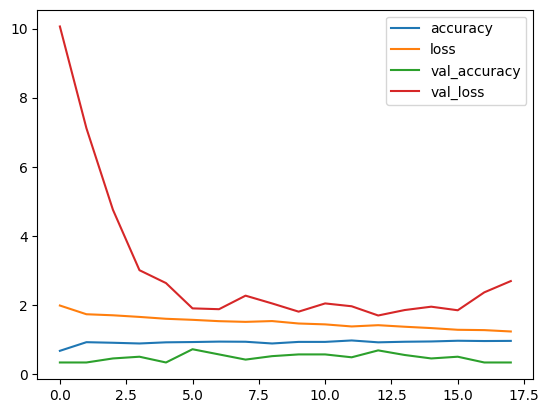

In [17]:
pd.DataFrame(history.history).plot()

In [18]:
model.save('potato_leaf_model.h5')

In [20]:
model.save('/content/drive/MyDrive/my_model.keras')


In [21]:
import os

# Path where the model is saved
model_path = '/content/drive/MyDrive/my_model.keras'

# Check if the file exists
if os.path.exists(model_path):
    print("Model file exists!")
else:
    print("Model file not found!")


Model file exists!


PREDECTION ON RANDOM DATA


In [27]:
# Update these paths according to the location in your Google Drive
Early_Blight_path = '/content/early_blighr.B 7306.JPG'
Healthy_path = '/content/Potato_healthy-26-_0_4635.jpg'
Late_Blight_path = '/content/late_blight.JPG'


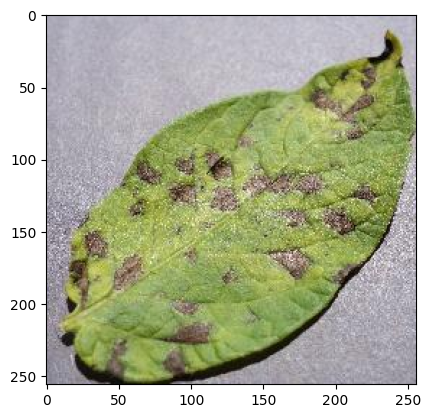

In [28]:

# Read the image using imread
Early_Blight_image = mpimg.imread(Early_Blight_path)

# Display the image using imshow
plt.imshow(Early_Blight_image)
plt.show()

In [29]:
import numpy as np
import matplotlib.image as mpimg

# Specify the path to the image file
#Early_Blight_path = '/kaggle/input/potato-disease-leaf-datasetpld/PLD_3_Classes_256/Testing/Early_Blight/Early_Blight_1.jpg'

# Read the image using imread
Early_Blight_image = mpimg.imread(Early_Blight_path)

# Normalize the image
Early_Blight_image_normalized = Early_Blight_image / 255.0

# Reshape the image
Early_Blight_image_reshaped = np.reshape(Early_Blight_image_normalized, (-1, 256, 256, 3))

In [30]:
predictions = model.predict(Early_Blight_image_reshaped)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [31]:
print((predictions>0.5).astype("int"))

[[0 0 1]]


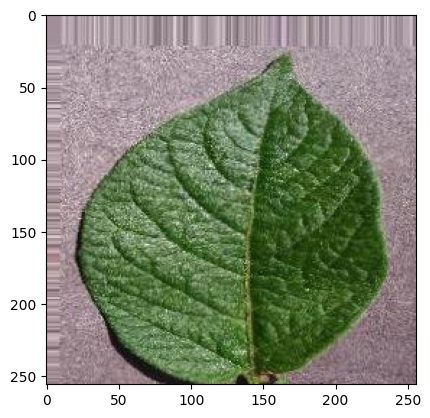

In [33]:
# Read the image using imread
Healthy_leaf_image = mpimg.imread(Healthy_path)

# Display the image using imshow
plt.imshow(Healthy_leaf_image)
plt.show()

In [35]:
import numpy as np
import matplotlib.image as mpimg


# Read the image using imread
Healthy_leaf_image = mpimg.imread(Healthy_path)

# Normalize the image
Healthy_leaf_image_normalized = Healthy_leaf_image / 255.0

# Reshape the image
Healthy_leaf_image_reshaped = np.reshape(Healthy_leaf_image_normalized, (-1, 256, 256, 3))

In [36]:
print((predictions>0.5).astype("int"))

[[0 0 1]]


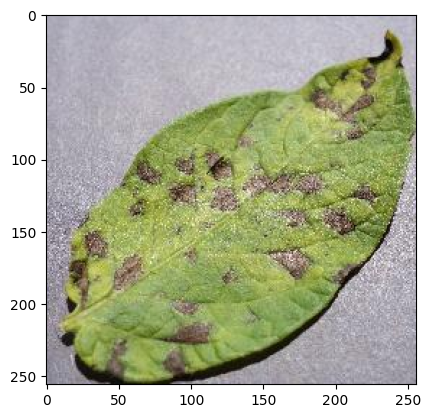

In [37]:
# Read the image using imread
Late_Blight_image = mpimg.imread(Early_Blight_path)

# Display the image using imshow
plt.imshow(Late_Blight_image)
plt.show()


In [38]:
Late_Blight_image = mpimg.imread(Late_Blight_path)

# Normalize the image
Late_Blight_image_normalized = Late_Blight_image / 255.0

# Reshape the image
Late_Blight_image_reshaped = np.reshape(Late_Blight_image_normalized, (-1, 256, 256, 3))

In [39]:
predictions = model.predict(Late_Blight_image_reshaped)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


In [40]:
print((predictions>0.5).astype("int"))

[[0 1 0]]
